# Taylor made keras model
I have uploaded the notebook I used for building the best NN model of our ensemble. It is not cleaned but maybe could be h

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob
import seaborn as sns
from termcolor import colored
import keras
from sklearn.model_selection import KFold
from tqdm import tqdm
import sys
import hyperopt
from hyperopt import fmin, tpe, hp
import time
import cPickle
import scipy.stats as ss

from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras import regularizers
from keras.models import Model
from keras.layers import Concatenate

from porto.definitions import TRAIN_SET_PATH, TEST_SET_PATH, DATA_DIR
from porto.dataset import DatasetCleaner, DatasetBuilder
from porto.metrics import gini_normalized

%matplotlib inline

## Gather the data

In [2]:
df_train = pd.read_csv(TRAIN_SET_PATH)
df_test = pd.read_csv(TEST_SET_PATH)

Clean the missing values

In [3]:
dataset_cleaner = DatasetCleaner(min_category_samples=50)
dataset_cleaner.fit(df_train)
dataset_cleaner.transform(df_train)
dataset_cleaner.transform(df_test)

Get rid of calc features.

In [4]:
unwanted = df_train.columns[df_train.columns.str.startswith('ps_calc_')]
df_train.drop(unwanted, axis=1, inplace=True)
df_test.drop(unwanted, axis=1, inplace=True)
print df_train.shape

### One hot encoding
Apply one hot encoding to categorical features.

In [5]:
categorical_columns = df_train.columns[df_train.columns.str.endswith('_cat')]
df_train = pd.concat([pd.get_dummies(df_train, columns=categorical_columns), df_train[categorical_columns]], axis=1)
df_test = pd.concat([pd.get_dummies(df_test, columns=categorical_columns), df_test[categorical_columns]], axis=1)
print df_train.shape, df_test.shape

In [6]:
df_train[df_train.columns[df_train.columns.str.startswith(categorical_columns[7])]].head(15)

### Custom binary encoding
Apply custom binary encoding to discrete numeric features.

In [7]:
numerical_discrete_features = ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 
                               'ps_reg_01', 'ps_reg_02',
                               'ps_car_15', 'ps_car_11']

In [8]:
def apply_custom_binary_encoding(column):
    column_values = df_train[column]
    unique_values = sorted(df_train[column].unique())
    for i, value in enumerate(unique_values[0:-1]):
        new_column_name = '%s_cbe%02d' % (column, i)
        df_train[new_column_name] = (df_train[column] > value).astype(np.int)
        df_test[new_column_name] = (df_test[column] > value).astype(np.int)

In [9]:
for column in numerical_discrete_features:
    apply_custom_binary_encoding(column)
print df_train.shape, df_test.shape

In [10]:
df_train[df_train.columns[df_train.columns.str.startswith('ps_ind_01')]].head(15)

### Target encoding

In [11]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))


def target_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [12]:
target_encoding_columns = list(numerical_discrete_features) + list(categorical_columns)
for f in target_encoding_columns:
    df_train[f + "_tef"], df_test[f + "_tef"] = target_encode(trn_series=df_train[f],
                                         tst_series=df_test[f],
                                         target=df_train['target'],
                                         min_samples_leaf=200,
                                         smoothing=10,
                                         noise_level=0)
print df_train.shape, df_test.shape

In [13]:
df_train.head()

### Normalize numerical columns

In [14]:
numerical_columns = [column for column in df_train.columns if not 'bin' in column and not 'cat' in column]
numerical_columns = [column for column in numerical_columns if not 'cbe' in column and not 'tef' in column]
numerical_columns = [column for column in numerical_columns if column.startswith('ps_')]
tfe_columns = [column for column in df_train.columns if 'tef' in column]

normalize_columns = numerical_columns + tfe_columns

In [15]:
for column in normalize_columns:
    mean_value = df_train[column].mean()
    std_value = df_train[column].std()
    df_train[column] = (df_train[column] - mean_value)/std_value
    df_test[column] = (df_test[column] - mean_value)/std_value
    
    max_value = np.maximum(df_train[column].max(), -df_train[column].min())
    MAX_VALUE_ALLOWED = 5.
    if max_value > MAX_VALUE_ALLOWED:
        scale = MAX_VALUE_ALLOWED/max_value
        df_train[column] *= scale
        df_test[column] *= scale

### Organize the columns for feeding the network

Remove categorical columns because they have been encoded and we don't need them any more.

In [16]:
df_train.drop(categorical_columns, axis=1, inplace=True)
df_test.drop(categorical_columns, axis=1, inplace=True)
print df_train.shape, df_test.shape

Now we have to divide the features by individual, region and car.
We also have to divide them between categorical and non-categorical. In the categorical columns I will encode the custom binary encoding features. In the non-categorical columns I will include the target encode of categorical columns 

In [17]:
df_train.columns

In [18]:
column_dict = {}
for key in ['car', 'ind', 'reg']:
    column_dict[key] = [column for column in df_train.columns if key in column]
    column_dict['%s_categorical' % key] = [column for column in column_dict[key] if '_cbe' in column or 'cat_' in column]
    column_dict['%s_categorical' % key] = [column for column in column_dict['%s_categorical' % key] if 'tef' not in column]
    column_dict[key] = [column for column in column_dict[key] if column not in column_dict['%s_categorical' % key]]
for key in column_dict:
    print key, len(column_dict[key])

In [19]:
for key in column_dict:
    print key
    print column_dict[key]
    print

### Prepare the data for keras

In [20]:
x = {key: df_train[column_dict[key]].values for key in column_dict}

In [21]:
x_test = {key: df_test[column_dict[key]].values for key in column_dict}

In [22]:
y = df_train.target.values
ids = df_train.id.values

In [23]:
column_dict[key]

### Load the test prediction of the best model

In [24]:
def load_save_dict(filename):
    with open(filename, 'r') as f:
        save_dict = cPickle.load(f)
    return save_dict
keras_save_dict = load_save_dict('/media/guillermo/Data/Kaggle/Porto_Safe_Driver/experiments/keras_log_20_5folds/2017_11_05_07_51_47.pkl')
best_test_pred= keras_save_dict['test_pred'][:, 0]

In [25]:
keras_save_dict = load_save_dict('/media/guillermo/Data/Kaggle/Porto_Safe_Driver/experiments/keras_log_20_5folds/2017_11_05_07_51_47.pkl')

In [26]:
best_test_pred= keras_save_dict['test_pred'][:, 0]

In [27]:
val_pred = keras_save_dict['val_pred'][:, 0]
sampling_probabilities = np.abs(df_train.target.values - val_pred)

## Function for getting the score

In [28]:
def save_log(filepath, params, time_stamp, gini_val_list, 
             gini_train_list, best_epoch_list, new_gini_val_list, 
             gini_test, optimizer_score):
    if not os.path.exists(filepath):
        with open(filepath, 'w') as f:
            f.write('\t'.join(['timestamp', 'new_gini_val_score', 'gini_test', 'gini_val_mean', 
                               'gini_train_mean', 'best_epoch',
                               'gini_val_std', 'gini_train_std','params']) + '\n')
    with open(filepath, 'a') as f:
        text = time_stamp + '\t'
        text += '%.4f\t%.4f\t%.4f\t' % (new_gini_val_list[-1], gini_test, optimizer_score)
        text += '%.4f\t%.4f\t' % (np.mean(gini_val_list), np.mean(gini_train_list))
        text += '%.1f\t' % np.mean(best_epoch_list)
        text += '%.4f\t%.4f\t%s\n' % (np.std(gini_val_list), np.std(gini_train_list), params)
        f.write(text)

In [29]:
def get_keras_model(encoding_conf, layers, dropout_rates, l1=0, l2=0, encoding_activation='relu'):
    # Create the encoding
    encoding_list = []
    input_list = []
    for key in ['reg', 'car', 'ind']:
        categorical_key = '%s_categorical' % key
        input_layer = Input(shape=(x[categorical_key].shape[1],), name=categorical_key)
        input_list.append(input_layer)
        encoding = Dense(int(encoding_conf[categorical_key]), 
                         activation=encoding_activation, name='%s_encoding' % categorical_key, 
                        kernel_regularizer=regularizers.l1_l2(l1, l2))(input_layer)
        input_layer = Input(shape=(x[key].shape[1],), name=key)
        input_list.append(input_layer)
        encoding_input = Concatenate(axis=1)([input_layer, encoding])
        encoding = Dense(int(encoding_conf[key]), activation=encoding_activation, name='%s_encoding' % key,
                        kernel_regularizer=regularizers.l1_l2(l1, l2))(encoding_input)
        encoding_list.append(encoding)
        
    encoding = Concatenate(axis=1)(encoding_list)
    
    first_layer = True
    for n_units, drop in zip(layers, dropout_rates):
        if first_layer:
            output = Dense(n_units, activation='relu')(encoding)
            first_layer = False
        else:
            output = Dense(n_units, activation='relu')(output)
        if drop > 0:
            output = Dropout(drop)(output)
    # Add the final layer
    output = Dense(1, activation='sigmoid', name='output')(output)
    
    model = Model(inputs=input_list, outputs=output)
    model.compile(loss='binary_crossentropy',  optimizer='RMSprop')
    return model

In [30]:
def get_upsampled_index(y, train_index, n_upsampling):
    positive_index = train_index[y[train_index] == 1]
    upsampled_index = train_index.tolist() + positive_index.tolist()*(n_upsampling)
    np.random.shuffle(upsampled_index)
    return upsampled_index

In [31]:
def get_noisy_target(y, prob):
    if prob == 0:
        return y
    noise = np.random.binomial(1, prob, y.shape)
    noisy_target = noise + y
    noisy_target[noisy_target == 2] = 0
    return noisy_target

In [32]:
def plot_train_evolution(val_score):
    plt.figure(figsize=(12, 6))
    plt.plot(val_score, label='val')
    plt.plot(val_score, 'ro')
    plt.ylabel('validation score')
    plt.xlabel('Number of epochs')
    plt.ylim(ymin=np.max(val_score) - 0.01)
    plt.show()

In [33]:
def get_score(params):
    # Get the parameters for the model
    model_layers = [int(params['n_units_per_layer'])]*int(params['n_layers'])
    model_dropout_rates = [params['dropout_rate']]*int(params['n_layers'])    
    
    time_stamp = time.strftime("%Y_%m_%d_%H_%M_%S")
    gini_train_list, gini_val_list, best_epoch_list  = [], [], []
    test_pred_list, val_pred_list, val_id_list = [], [], []
    new_gini_val_list = []
    
    random_state = -1
    sys.stdout.flush()
    for i in tqdm(range(params['max_experiments'])):
        random_state += 1
        
        fold_val_ids = []
        unsorted_val_preds = []
        
        for n_fold in range(params['n_folds']):
            kf = KFold(n_splits=params['n_folds'], shuffle=True, random_state=random_state)
            partitions = [_ for _ in kf.split(y)]
            train_index, val_index = partitions[n_fold]

            x_train = {key:x[key][train_index] for key in x}
            x_val = {key:x[key][val_index] for key in x}
            upsampled_probs = y[train_index]*params['n_upsampling'] + 1
            train_sample_probs = sampling_probabilities[train_index]
            train_sample_probs *= upsampled_probs
            train_sample_probs /= np.sum(train_sample_probs)
            #print 'train_sample_probs: ', train_sample_probs[0:20]

            model = get_keras_model(params['encoding_conf'], encoding_activation=params['encoding_activation'],
                                    layers=model_layers, dropout_rates=model_dropout_rates,
                                    l1=params['l1'], l2=params['l2'])

            model_gini_train_list = []
            model_gini_val_list = []
            best_weights = None
            for epoch in range(params['max_epochs']):
                for _ in range(params['val_period']):
                    epoch_index = np.random.choice(train_index, size=params['epoch_size'],
                                                   p=train_sample_probs, replace=False)
                    x_train_epoch = {key:x[key][epoch_index] for key in x}
                    model.fit(x=x_train_epoch, y=y[epoch_index], epochs=1, 
                              batch_size=params['batch_size'], verbose=False)

                preds_val = model.predict(x=x_val, batch_size=params['batch_size'])
                gini_val = gini_normalized(y[val_index], preds_val)
                model_gini_val_list.append(gini_val)

                best_epoch = np.argmax(model_gini_val_list)
                if best_epoch == epoch:
                    best_weights = model.get_weights()
                if epoch - best_epoch >= params['patience']:
                    break

            best_epoch = np.argmax(model_gini_val_list)
            best_epoch_list.append(best_epoch)
            gini_val_list.append(model_gini_val_list[best_epoch])

            model.set_weights(best_weights)
            preds_test = preds_val = model.predict(x=x_test, batch_size=params['batch_size'])
            test_pred_list.append(preds_test)

            preds_train = model.predict(x=x_train, batch_size=params['batch_size'])
            gini_train = gini_normalized(y[train_index], preds_train)
            gini_train_list.append(gini_train)

            preds_val = model.predict(x=x_val, batch_size=params['batch_size'])
            unsorted_val_preds.append(preds_val)
            fold_val_ids.append(ids[val_index])

            if params['verbose']:
                print colored('Gini val: %.4f\tGini train: %.4f' % (gini_val_list[-1], gini_train_list[-1]), 'blue')
                plot_train_evolution(model_gini_val_list)
        # Sort the validation predictions
        fold_val_ids = np.concatenate(fold_val_ids)
        unsorted_val_preds = np.concatenate(unsorted_val_preds)
        sorted_index = np.argsort(fold_val_ids)
        sorted_val_preds = unsorted_val_preds[sorted_index]
        val_pred_list.append(sorted_val_preds)
        # Get the gini validation score
        new_gini_val = gini_normalized(y, np.mean(val_pred_list, axis=0))
        new_gini_val_list.append(new_gini_val)
        # Get test score
        test_pred_mean = np.mean(test_pred_list, axis=0)
        gini_test = gini_normalized(best_test_pred, test_pred_mean)
        
        if params['verbose']:
            text = 'Gini val: %.4f\tGini test: %.4f' % (new_gini_val, gini_test)
            print colored(text, 'blue')
     
    gini_train_score = np.mean(gini_train_list)
    gini_val_score = np.mean(gini_val_list)
    gini_val = new_gini_val_list[-1]
    
    
    print time_stamp
    print colored('params: %s' % params, 'green')
    print colored('Gini val score: %.4f' % gini_val, 'green')
    print colored('Gini test score: %.4f' % gini_test, 'green')
    
    optimizer_score = gini_test - 2.9949206966767021*gini_val - 0.12420528931875374
    
    save_log(params['log_file'], params, time_stamp, gini_val_list, 
             gini_train_list, best_epoch_list, new_gini_val_list,
             gini_test, optimizer_score)
    save_dict = {
        'gini_test': gini_test,
        'test_pred': test_pred_mean,
        'val_pred': np.mean(val_pred_list, axis=0),
        'new_gini_val_list': new_gini_val_list,
        'gini_train_list': gini_train_list,
        'gini_val_list': gini_val_list,
        'params': params,
        'time_stamp': time_stamp,
        'best_epoch_list': best_epoch_list,
    }
    dirname = os.path.splitext(os.path.basename(params['log_file']))[0]
    pickle_path = os.path.join(DATA_DIR, 'experiments', dirname, '%s.pkl' % time_stamp)
    if not os.path.exists(os.path.dirname(pickle_path)):
        os.mkdir(os.path.dirname(pickle_path))
    with open(pickle_path, 'w') as f:
        cPickle.dump(save_dict, f)
        
    
    
    return optimizer_score

## Speed up

I think there are too much evaluations, let's divide them by 4 and 2

In [34]:
sampling_probabilities[:] = 1

In [35]:
raise

TypeError: exceptions must be old-style classes or derived from BaseException, not NoneType

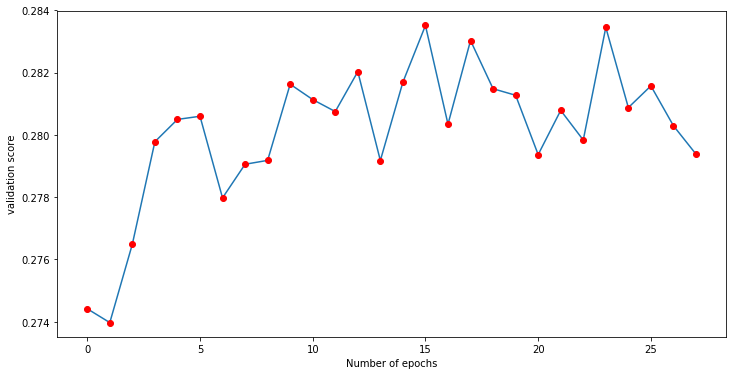

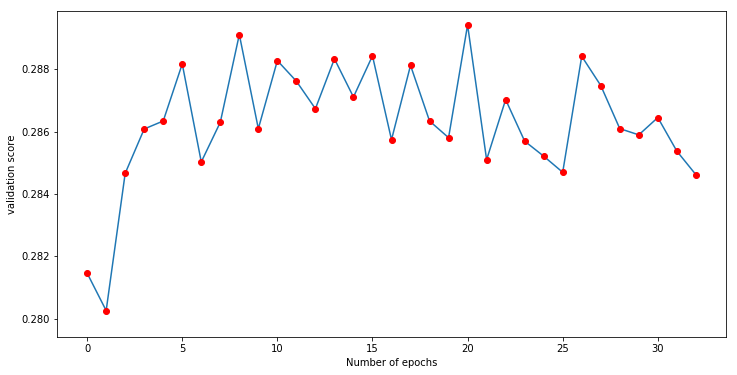

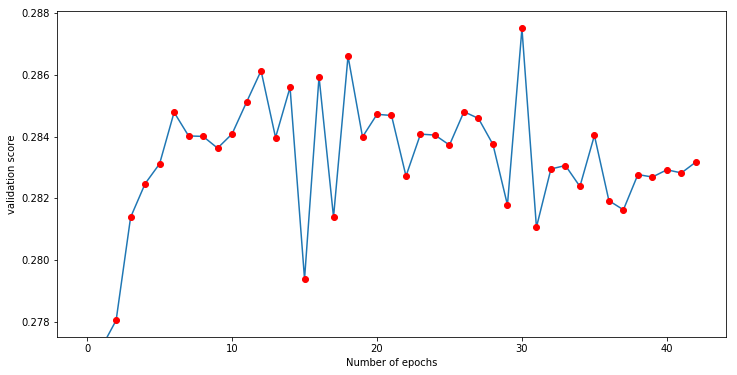

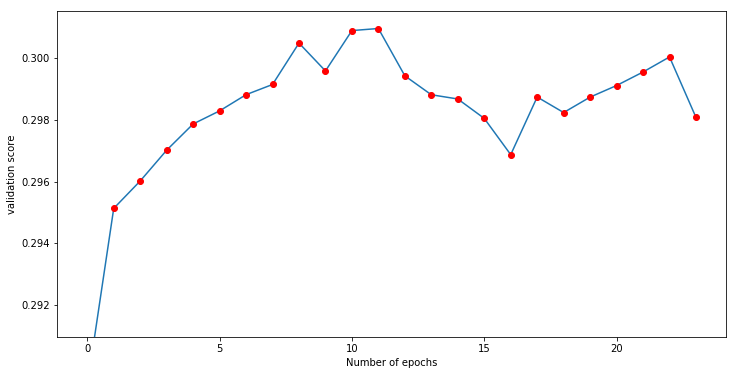

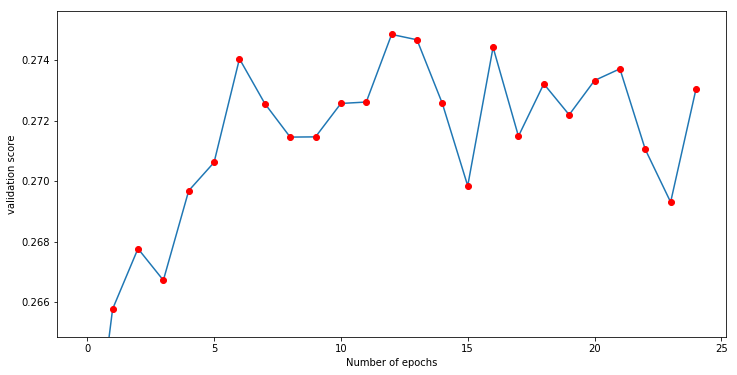

KeyboardInterrupt: 

In [36]:
params = {
    'encoding_conf': {
        'reg_categorical': 3.0, 
        'car_categorical': 1, 
        'ind_categorical': 50.0, 
        'ind': 70.0, 
        'car': 35.0, 
        'reg': 34.0}, 
    'n_layers': 1, 
    'n_units_per_layer': 90.0, 
    'dropout_rate': 0.5, 
    'encoding_activation': 'tanh', 
    
    'l2': 0.0001, 
    'l1': 1e-05, 
    
    'batch_size': 2048,
    'val_period': 4,
    'epoch_size': 100000, 
    'patience': 12, 
    'n_upsampling': 25, 
    'n_folds': 5, 
    'max_epochs': 1000, 
    'max_experiments': 10, 
    'verbose': True, 
    'log_file': '../logs/keras_v31_5folds.csv'}
get_score(params)

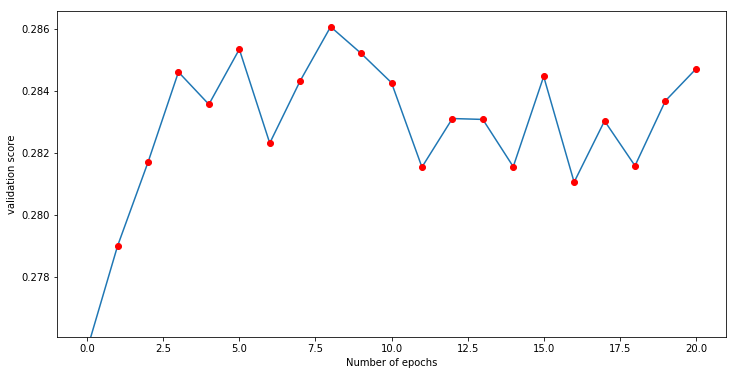

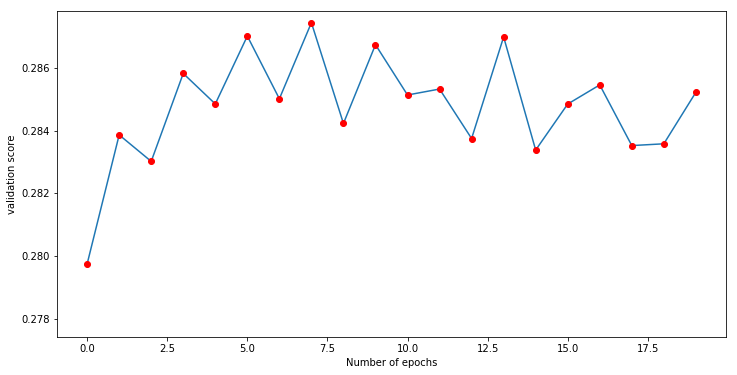

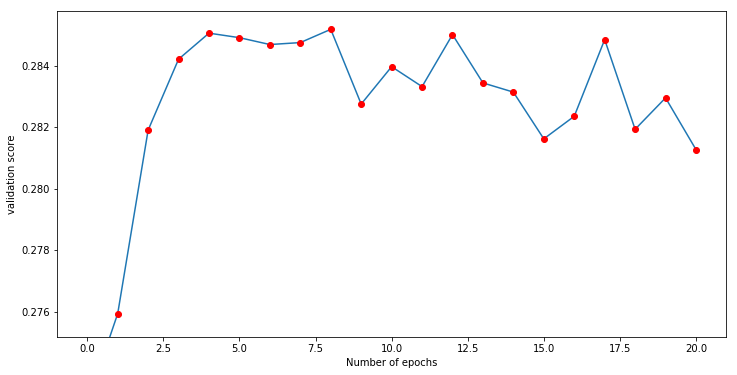

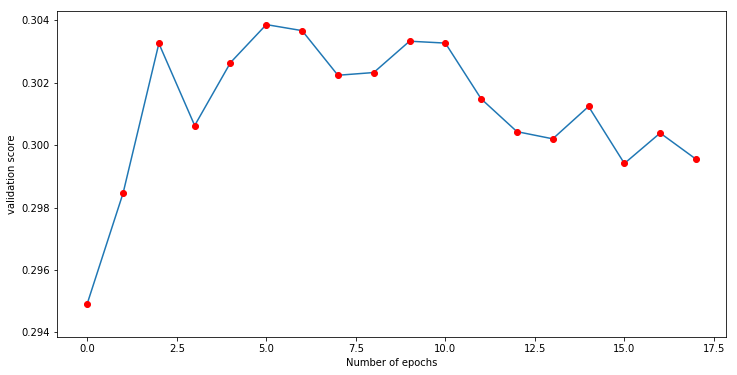

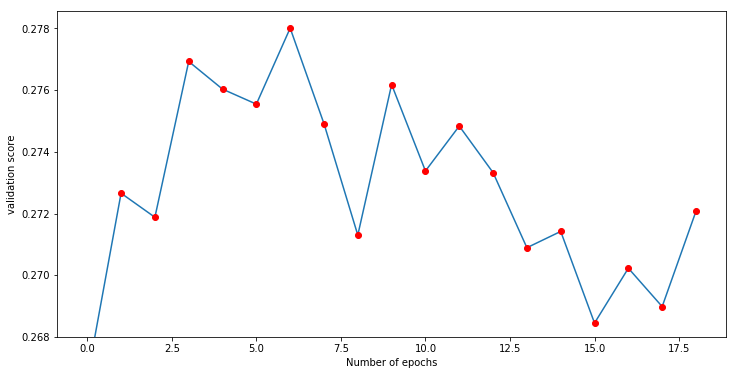

KeyboardInterrupt: 

In [37]:
params = {
    'encoding_conf': {
        'reg_categorical': 3.0, 
        'car_categorical': 1, 
        'ind_categorical': 50.0, 
        'ind': 70.0, 
        'car': 35.0, 
        'reg': 34.0}, 
    'n_layers': 1, 
    'n_units_per_layer': 90.0, 
    'dropout_rate': 0.5, 
    'encoding_activation': 'tanh', 
    
    'l2': 0.0001, 
    'l1': 1e-05, 
    
    'batch_size': 2048,
    'val_period': 8,
    'epoch_size': 50000, 
    'patience': 12, 
    'n_upsampling': 25, 
    'n_folds': 5, 
    'max_epochs': 1000, 
    'max_experiments': 10, 
    'verbose': True, 
    'log_file': '../logs/keras_v31_5folds.csv'}
get_score(params)

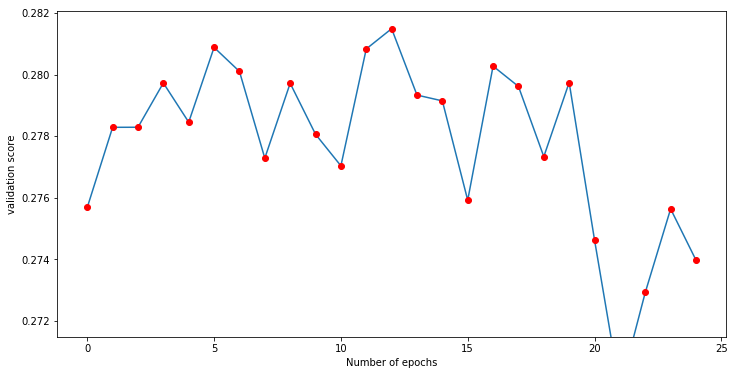

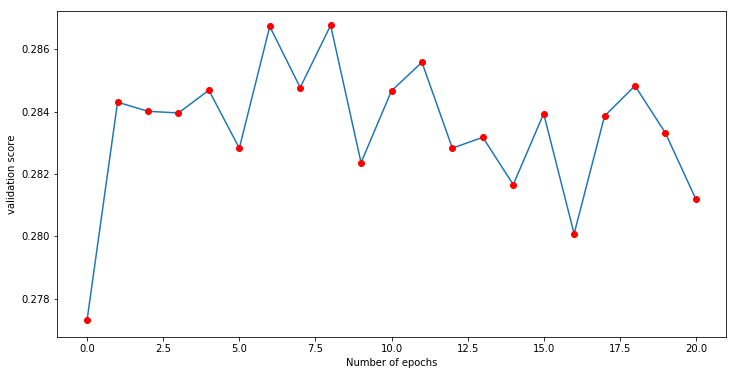

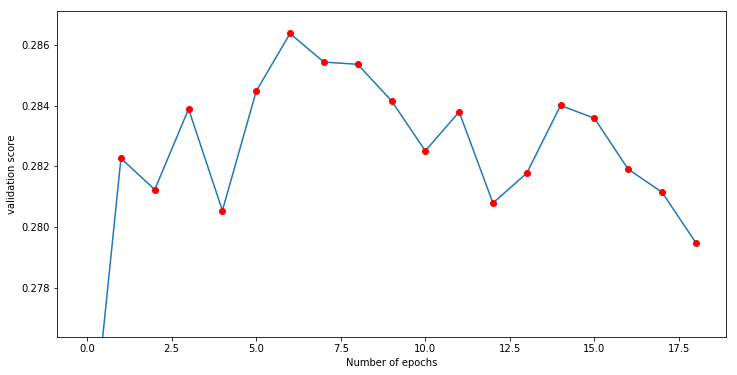

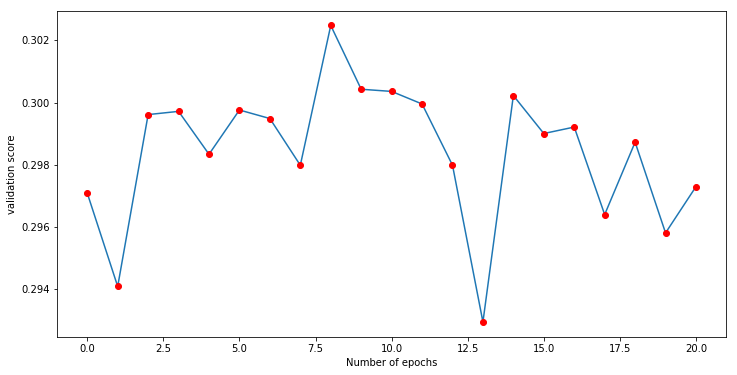

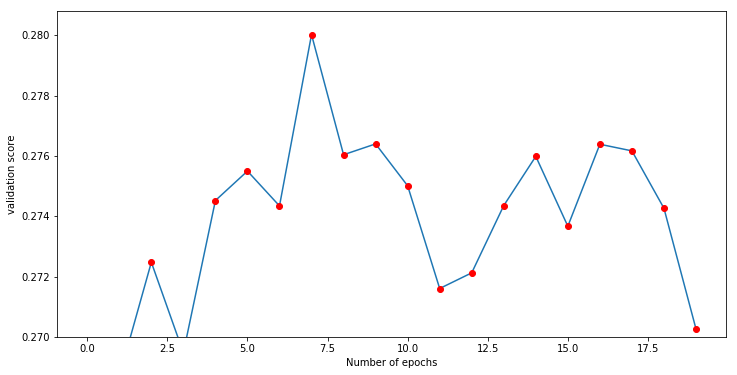

KeyboardInterrupt: 

In [38]:
params = {
    'encoding_conf': {
        'reg_categorical': 3.0, 
        'car_categorical': 1, 
        'ind_categorical': 50.0, 
        'ind': 70.0, 
        'car': 35.0, 
        'reg': 34.0}, 
    'n_layers': 1, 
    'n_units_per_layer': 90.0, 
    'dropout_rate': 0.5, 
    'encoding_activation': 'tanh', 
    
    'l2': 0.0001, 
    'l1': 1e-05, 
    
    'batch_size': 2048,
    'val_period': 16,
    'epoch_size': 25000, 
    'patience': 12, 
    'n_upsampling': 25, 
    'n_folds': 5, 
    'max_epochs': 1000, 
    'max_experiments': 10, 
    'verbose': True, 
    'log_file': '../logs/keras_v31_5folds.csv'}
get_score(params)